<div style="text-align: right"> York University - ML1030 - Julia Mitroi </div>

# Sentiment Analysis for Movie Reviews

## Text Pre-processing/Normalization

### Installing libraries and packages

In [13]:
import os
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
nltk.download('stopwords')
nltk.download('punkt')

import re

import keras

from keras.utils import to_categorical
import random
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Embedding, LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics


# random seed for the session & for tensorflow that runs in background for keras
set_random_seed(123)
random.seed(123)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julia.mitroi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\julia.mitroi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
train_reviews = pd.read_csv("train.tsv", sep="\t")

In [3]:
test_reviews = pd.read_csv("test.tsv", sep="\t")

### Data Cleaning

In [4]:
# Make reviews text lowercase
train_reviews['Phrase'] = train_reviews['Phrase'].str.lower()
test_reviews['Phrase'] = test_reviews['Phrase'].str.lower()

In [5]:
train_reviews['Phrase'].head()

0    a series of escapades demonstrating the adage ...
1    a series of escapades demonstrating the adage ...
2                                             a series
3                                                    a
4                                               series
Name: Phrase, dtype: object

In [6]:
# Leaving only letters from a-z and digits
train_reviews['Phrase'] = train_reviews['Phrase'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
test_reviews['Phrase'] = test_reviews['Phrase'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [7]:
# Removing HTML content
train_reviews['Phrase'] = [BeautifulSoup(text).get_text() for text in train_reviews['Phrase']]
test_reviews['Phrase'] = [BeautifulSoup(text).get_text() for text in test_reviews['Phrase']]

### Treebank Tokenization

In [8]:
# Using the Penn U.'s' Treebank Word Tokenazer from ftp://ftp.cis.upenn.edu/pub/treebank/public_html/tokenization.html
# Through tokenization, each sentence is converterd to a sequence of tokens. 

from nltk.tokenize import TreebankWordTokenizer 

treebank_tokenizer = TreebankWordTokenizer()

def tokenize(t):
    return ' '.join(treebank_tokenizer.tokenize(t))

sentences = train_reviews.Phrase.apply(tokenize)

### Lemmatization

In [9]:
# NLTK's WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize(l):
    return ' '.join([lemmatizer.lemmatize(s) for s in l.split(' ')])    
    
sentences = sentences.apply(lemmatize)

### Stemming

In [10]:
# NLTK's Stemmer
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem(s):
    return ' '.join([stemmer.stem(w) for w in s.split(' ')])

sentences = sentences.apply(stem)

In [11]:
sentences.head()

0    a seri of escapad demonstr the adag that what ...
1    a seri of escapad demonstr the adag that what ...
2                                               a seri
3                                                    a
4                                                 seri
Name: Phrase, dtype: object

### Keras Pre-processing

In [15]:
# Preliminary to modeling, I will use Keras text preprocessing functions to further pre-process the sentences in the 
# train set, namely to transform the text into sequences of tokens, and pad those sequences to have the same length.

tokenizer = Tokenizer()
# fit_on_texts function creates vocabulary index based on word frequency in sentences
tokenizer.fit_on_texts(sentences)

# texts_to_sequences transforms each text in the sentences set to a sequence of integers
X = tokenizer.texts_to_sequences(sentences)

from keras.preprocessing.sequence import pad_sequences
# pad_sequences performs sequences padding
X = pad_sequences(X)

# Constructing the target
Y = pd.get_dummies(train_reviews.Sentiment).values

In [24]:
# Vocabulary Size.
vocab_size = len(tokenizer.word_index) + 1

print("Vocabulary size: ", vocab_size)
print("X's shape : " , X.shape)
print("Y's shape : " , X.shape)

Vocabulary size:  11965
X's shape :  (156060, 48)
Y's shape :  (156060, 48)


## Modeling

### Baseline Model Accuracy

In [25]:
from sklearn.metrics import accuracy_score
# Before building a deep learning model, I am computing the baseline accuracy classification score
print('Baseline Accuracy Classification Score: ', accuracy_score(train_reviews.Sentiment.values[-1000:] , [3 for _ in range(1000)]))

Baseline Accuracy Classification Score:  0.213


### LSTM + Dense NN Architecture

In [26]:
from keras.models import Sequential , load_model , Model
from keras.layers import Dense , LSTM, Dropout , Conv1D , MaxPooling1D , Input, Reshape , Masking , TimeDistributed
from keras.layers import Concatenate , BatchNormalization , Bidirectional , Activation , GlobalMaxPooling1D
from keras.preprocessing.sequence import TimeseriesGenerator , pad_sequences
from keras.callbacks import History , ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.constraints import maxnorm
from keras.regularizers import l1_l2

from keras.layers import Embedding
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , precision_score , accuracy_score
from sklearn.metrics import recall_score , confusion_matrix, roc_curve, auc

In [29]:
# Model Definition, using Keras Sequential Model:
# LSTM Network followed by a regular densely-connected (fully connected) Neural Network layer, using an embedding Layer 

def model(X , Y , embed_dim , vocab_size,
          lstm_layers = [] , lstm_dropout = [],
          dense_layers = [] , dense_dropout = [] ,
          ntest_sers = 400 , epochs = 10 , batch_size = 32 , lr = 0.001):
        
    # training and testing set :
    length  = X.shape[0] 
    target_shape = Y.shape[1]
    
    # Validation rate to pass to the Sequential Model:
    val_rate = ntest_sers/length
    
    # Model:
    
    history = History()
    checkpoint = ModelCheckpoint('model' , save_best_only=True)
    
    # As first layer in a sequential model:
    model = Sequential()
    # Embeding layer
    model.add(Embedding(vocab_size, embed_dim,input_length = X.shape[1]))
    
    if len(lstm_layers) == 0:
        model.add(GlobalMaxPooling1D())
    
    # LSTM Layers
    for i in range(len(lstm_layers)):
        
        rsequs  = not (i == (len(lstm_layers) - 1))
        model.add(LSTM(lstm_layers[i] , return_sequences = rsequs) )
        
        if len(lstm_dropout)>0:
            model.add(Dropout(lstm_dropout[i]))
                      
    # Dense NN Layers        
    for i in range(len(dense_layers)):
         
        model.add(Dense(dense_layers[i] , activation = 'relu') )
        
        if len(dense_dropout)>0:
            model.add(Dropout(dense_dropout[i]))  
        
    model.add(Dense(target_shape , activation = 'softmax'))
    
    Nadam = keras.optimizers.Nadam(lr = lr , beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer= Nadam , metrics = ['accuracy'])

    # fitting the data
    model.fit(X, Y, epochs= epochs, batch_size=batch_size, validation_split = val_rate ,
              callbacks = [history , checkpoint])
    
    # loading best_model
    model = load_model('model')
              
    # loading best_model
    return model , min(history.history['val_loss'])

In [30]:
val = 1000

results = model( X , Y , embed_dim = 256 , vocab_size = vocab_size,
               lstm_layers = [128] , lstm_dropout = [.5 , .5],
               dense_layers = [64] , dense_dropout = [.5],
               batch_size = 256 , epochs = 10 , ntest_sers = val , lr = 0.001 )


Train on 155060 samples, validate on 1000 samples
Epoch 1/10
155060/155060 [==============================] - 266s 2ms/step - loss: 1.0368 - acc: 0.5879 - val_loss: 0.9351 - val_acc: 0.6040
Epoch 2/10
155060/155060 [==============================] - 276s 2ms/step - loss: 0.8167 - acc: 0.6653 - val_loss: 0.9727 - val_acc: 0.5950
Epoch 3/10
155060/155060 [==============================] - 272s 2ms/step - loss: 0.7507 - acc: 0.6876 - val_loss: 0.9568 - val_acc: 0.6000
Epoch 4/10
155060/155060 [==============================] - 265s 2ms/step - loss: 0.7098 - acc: 0.7002 - val_loss: 0.9626 - val_acc: 0.5890
Epoch 5/10
155060/155060 [==============================] - 258s 2ms/step - loss: 0.6760 - acc: 0.7102 - val_loss: 1.0022 - val_acc: 0.5940
Epoch 6/10
155060/155060 [==============================] - 259s 2ms/step - loss: 0.6529 - acc: 0.7181 - val_loss: 1.0533 - val_acc: 0.6000
Epoch 7/10
155060/155060 [==============================] - 269s 2ms/step - loss: 0.6303 - acc: 0.7254 - val_l

### Model Performance

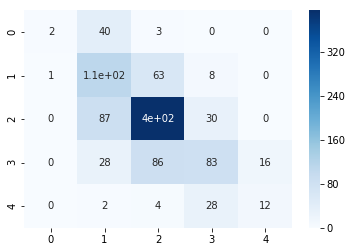

accuracy : 0.604
precisions : [0.66666667 0.4141791  0.7173913  0.55704698 0.42857143]
recalls : [0.04444444 0.60655738 0.77192982 0.38967136 0.26086957]
class no : 0


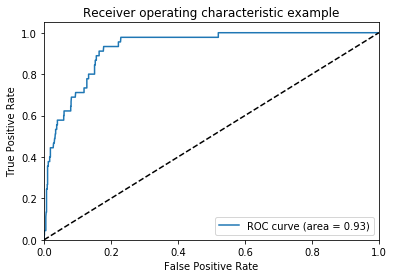

class no : 1


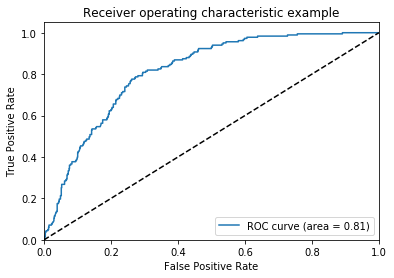

class no : 2


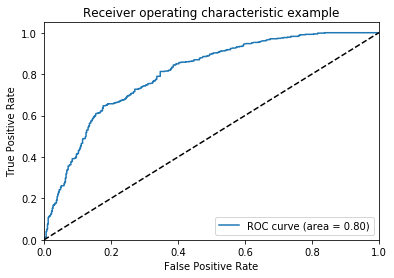

class no : 3


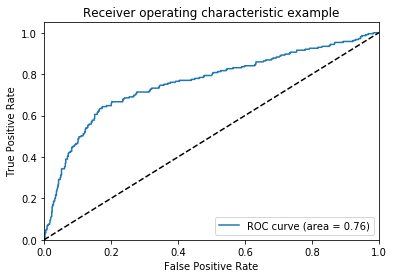

class no : 4


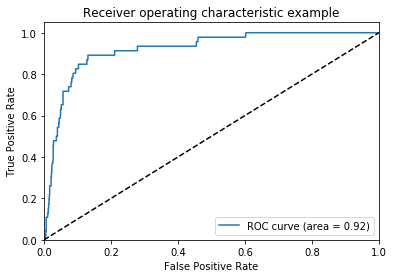

In [34]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
#from matplotlib.pyplot import *

# prediction
y_score = results[0].predict(X[-val:])
y_pred = np.argmax(y_score , axis = 1)

# True values
y_test = train_reviews.Sentiment.values[-val:]

# Confusion matrix
hmap = confusion_matrix(y_test , y_pred)
sns.heatmap(hmap , cmap = 'Blues' , annot = True)
plt.show()

# Metrics :
print('accuracy :' , accuracy_score(y_test , y_pred))
print('precisions :' , precision_score(y_test , y_pred , average = None))
print('recalls :' , recall_score(y_test , y_pred , average = None))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 5

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score[:, i] , pos_label = i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for each class (Sentiment label)
for i in range(n_classes):
    print('class no :' , i )
    
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Model accuracy = 60.4%

Using area under ROC curve (AUC) as a measure of quality of the classification model:
ROC for Sentiment 0 = 93%
ROC for Sentiment 1 = 81%
ROC for Sentiment 1 = 80%
ROC for Sentiment 1 = 76%
ROC for Sentiment 1 = 92%

(An area under the ROC curve of 0.9 means that a randomly selected case from the group with the target = 1 has a score larger than that for a randomly chosen case from the group with the target = 0 in 90% of the time.)

Best quality of classification for Sentiments based on applying the model above: for Sentiments 0 ("negative") and 4 ("positive").
